# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 200-2000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 


In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 14:46:15.637294
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=2000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 14:46:46.331417
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-29 14:46:49.688490
Load sequence...
2022-12-29 14:47:14.109410
Num IDs: 34915
Example IDs: [('ENSG00000187608', 'ENST00000624652.1'), ('ENSG00000162571', 'ENST00000673999.1'), ('ENSG00000186827', 'ENST00000699976.1'), ('ENSG00000160087', 'ENST00000422076.5')]
Count 17845 ones out of 34915 labels.
Example labels: [1, 0, 0, 1]
Num counts: 34915
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167, 155, 106, 168, 159, 123, 234, 165, 147, 73, 34, 133, 17, 67, 9, 35, 139, 41, 162

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 14:47:14.151765
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 1990, 64)          2112      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [10]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 14:47:17.401666
2022-12-29 14:47:17.401826
splitting
Fold 1
Training example
[ 74  39 154 ...   0   0   0]
Train sizes (27856, 1997) (27856, 1)
Valid sizes (7059, 1997) (7059, 1)
Train set ones/size 14271 / 27856
Valid set ones/size 3574 / 7059
BUILD MODEL
COMPILE
FIT
2022-12-29 14:47:21.513589
Epoch 1/5
871/871 [==============================] - 15s 6ms/step - loss: 0.6330 - accuracy: 0.6499 - val_loss: 0.6230 - val_accuracy: 0.6626
Epoch 2/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6147 - accuracy: 0.6694 - val_loss: 0.6144 - val_accuracy: 0.6743
Epoch 3/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6105 - accuracy: 0.6777 - val_loss: 0.6145 - val_accuracy: 0.6695
Epoch 4/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6081 - accuracy: 0.6773 - val_loss: 0.6144 - val_accuracy: 0.6718
Epoch 5/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6066 - accuracy: 0.6804 - val_loss: 0.6138 - val_accu

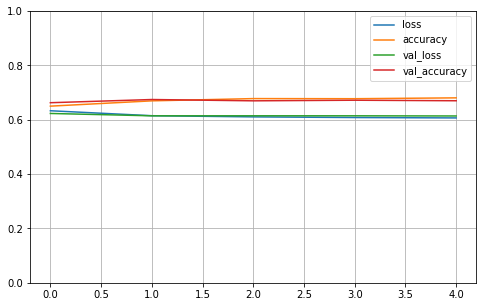

Compute valiation accuracy
2022-12-29 14:47:55.779333
Range of scores: 0.016464625 to 0.9847798
Predicted zeros and ones 3296 3763
Accuracy: 66.98% Precision: 66.52% Recall: 70.03% F1: 68.23%
2022-12-29 14:47:56.403204
Fold 2
Training example
[ 74  39 154 ...   0   0   0]
Train sizes (27895, 1997) (27895, 1)
Valid sizes (7020, 1997) (7020, 1)
Train set ones/size 14222 / 27895
Valid set ones/size 3623 / 7020
BUILD MODEL
COMPILE
FIT
2022-12-29 14:48:00.493555
Epoch 1/5
872/872 [==============================] - 5s 6ms/step - loss: 0.6310 - accuracy: 0.6504 - val_loss: 0.6238 - val_accuracy: 0.6613
Epoch 2/5
872/872 [==============================] - 5s 5ms/step - loss: 0.6119 - accuracy: 0.6761 - val_loss: 0.6205 - val_accuracy: 0.6654
Epoch 3/5
872/872 [==============================] - 5s 5ms/step - loss: 0.6077 - accuracy: 0.6773 - val_loss: 0.6265 - val_accuracy: 0.6584
Epoch 4/5
872/872 [==============================] - 5s 5ms/step - loss: 0.6058 - accuracy: 0.6788 - val_loss: 0.62

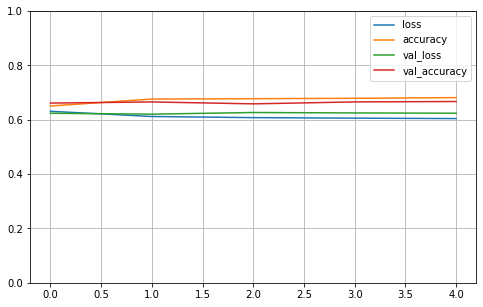

Compute valiation accuracy
2022-12-29 14:48:43.090820
Range of scores: 0.009504261 to 0.9869971
Predicted zeros and ones 3431 3589
Accuracy: 66.70% Precision: 67.90% Recall: 67.26% F1: 67.58%
2022-12-29 14:48:43.875792
Fold 3
Training example
[ 74  39 154 ...   0   0   0]
Train sizes (27851, 1997) (27851, 1)
Valid sizes (7064, 1997) (7064, 1)
Train set ones/size 14342 / 27851
Valid set ones/size 3503 / 7064
BUILD MODEL
COMPILE
FIT
2022-12-29 14:48:47.995780
Epoch 1/5
871/871 [==============================] - 6s 6ms/step - loss: 0.6289 - accuracy: 0.6553 - val_loss: 0.6387 - val_accuracy: 0.6392
Epoch 2/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6105 - accuracy: 0.6774 - val_loss: 0.6343 - val_accuracy: 0.6546
Epoch 3/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6059 - accuracy: 0.6821 - val_loss: 0.6358 - val_accuracy: 0.6518
Epoch 4/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6042 - accuracy: 0.6835 - val_loss: 0.63

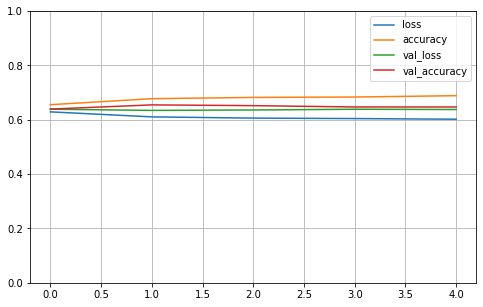

Compute valiation accuracy
2022-12-29 14:49:29.876098
Range of scores: 0.023467394 to 0.9905533
Predicted zeros and ones 3340 3724
Accuracy: 64.68% Precision: 63.53% Recall: 67.54% F1: 65.48%
2022-12-29 14:49:30.651526
Fold 4
Training example
[ 74  39 154 ...   0   0   0]
Train sizes (27866, 1997) (27866, 1)
Valid sizes (7049, 1997) (7049, 1)
Train set ones/size 14293 / 27866
Valid set ones/size 3552 / 7049
BUILD MODEL
COMPILE
FIT
2022-12-29 14:49:34.703883
Epoch 1/5
871/871 [==============================] - 6s 6ms/step - loss: 0.6351 - accuracy: 0.6404 - val_loss: 0.6132 - val_accuracy: 0.6872
Epoch 2/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6180 - accuracy: 0.6680 - val_loss: 0.6058 - val_accuracy: 0.6872
Epoch 3/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6135 - accuracy: 0.6730 - val_loss: 0.6058 - val_accuracy: 0.6869
Epoch 4/5
871/871 [==============================] - 5s 5ms/step - loss: 0.6121 - accuracy: 0.6710 - val_loss: 0.60

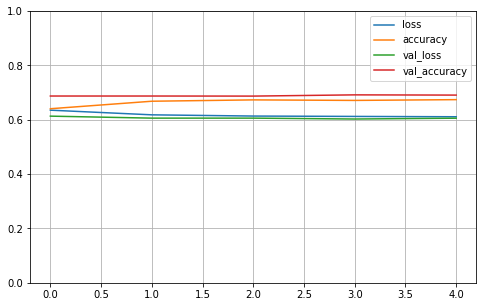

Compute valiation accuracy
2022-12-29 14:49:59.554442
Range of scores: 0.015712142 to 0.9885223
Predicted zeros and ones 3144 3905
Accuracy: 69.06% Precision: 67.55% Recall: 74.27% F1: 70.75%
2022-12-29 14:50:00.143341
Fold 5
Training example
[169 161 129 ...   0   0   0]
Train sizes (28192, 1997) (28192, 1)
Valid sizes (6723, 1997) (6723, 1)
Train set ones/size 14252 / 28192
Valid set ones/size 3593 / 6723
BUILD MODEL
COMPILE
FIT
2022-12-29 14:50:04.237821
Epoch 1/5
881/881 [==============================] - 5s 5ms/step - loss: 0.6356 - accuracy: 0.6425 - val_loss: 0.6047 - val_accuracy: 0.6853
Epoch 2/5
881/881 [==============================] - 4s 5ms/step - loss: 0.6180 - accuracy: 0.6671 - val_loss: 0.6008 - val_accuracy: 0.6995
Epoch 3/5
881/881 [==============================] - 4s 5ms/step - loss: 0.6130 - accuracy: 0.6723 - val_loss: 0.6026 - val_accuracy: 0.6939
Epoch 4/5
881/881 [==============================] - 4s 5ms/step - loss: 0.6111 - accuracy: 0.6707 - val_loss: 0.61

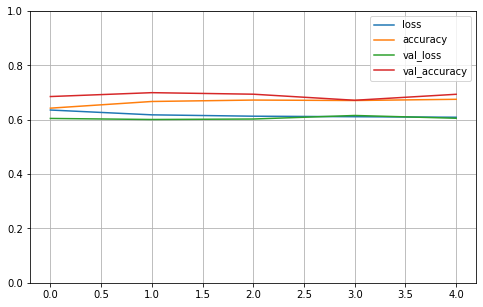

Compute valiation accuracy
2022-12-29 14:50:27.304934
Range of scores: 0.0109451255 to 0.9820823
Predicted zeros and ones 3244 3479
Accuracy: 69.36% Precision: 72.03% Recall: 69.75% F1: 70.87%
2022-12-29 14:50:28.075674

Cross validation 5 folds 5 epochs
 accuracy mean 67.35% +/- 1.71
 precision mean 67.51% +/- 2.74
 recall mean 69.77% +/- 2.51
 F1 mean 68.58% +/- 2.04
2022-12-29 14:50:28.078355


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())